<br>

<div align="center";><h3>King County, WA</h3>

<div align="center";><h1> Property Sale Data Analysis & Predictive Model</h1>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_theme()
import pickle
from datetime import datetime
import pytz
from pytz import common_timezones
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 100)

In [4]:
df = pd.read_csv('data/kc_house_data_train.csv', index_col='Unnamed: 0')
print(df.shape)
df.head()

(17290, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


# Initial EDA

I first explore the data to see how large the dataset is, what features I have to work with, and check for null values. This dataset fortunately does not have any null values, but that doesn't mean that no cleaning is necessary. For values that appear to be outliers or simply incorrect, I will evaluate case-by-case and impute values depending on the context.  
  
  As the CRISP-DM process involves consistently reevaluating data, my full EDA will involve exhaustive analysis and frequently reassessing each feature of the dataset.

- 17290 rows, each representing a recorded property sale
- 22 columns
  - 22 columns originally  
  - Target variable: **`price`**
  - Former column **'Unnamed: 0'** imported as index column
- 0 null values

The features of the dataset are the following:
- id
- date
- **price**
- bedrooms
- bathrooms
- sqft_living
- sqft_lot
- floors
- waterfront
- view
- condition
- grade
- sqft_above
- sqft_basement
- yr_built
- yr_renovated
- zipcode
- lat 
- long
- sqft_living15
- sqft_lot15

In [277]:
df.price.isna().sum() # checking for null values in target

0

### Checking Datatypes
The datatype for 'date' gets converted to datetime64[ns] in the cleaning process to be more manageable in creating features related to the date of sale, and to simply make referencing sale date easier.

In [278]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

# Cleaning, Feature Engineering, & Creating Dummy Variables

In [5]:
# CLEANING: formatting date column from ICS datetime to datetime64(ns) for easier manipulation with Pandas
df.date = pd.to_datetime(df['date'], format='%Y/%m/%d') 

# creates variable representing today with format matching the cleaned 'date' column formatting
today = pd.to_datetime(pd.Timestamp.today(), format='%Y/%m/%d') 

# FE: number representing how many years ago (from today) that the sale occurred
df['yrs_since_sale'] = pd.to_numeric((today-df.date)/(3.154*10**16)) 

# FE: number representing age of property in years
df['yrs_old'] = 2021-df.yr_built 

# FE: how many years since renovation
df['yrs_since_renovation'] = 2021-df.yr_renovated 

# CLEANING: corrects properties that have never been renovated for engineered feature 'yrs_since_renovation'
df['yrs_since_renovation'] = np.where(df.yrs_since_renovation == 2021, 
                                      df.yrs_old, 
                                      df.yrs_since_renovation)

# FE: how many years since renovation at year of sale, create from 'yrs_since_renovation' minus 'yrs_since_sale'
df['yrs_since_ren_at_sale'] = (df.yrs_since_renovation - df.yrs_since_sale) 

# FE: subtracts total property livable sq. ft. divided by number of floors from lot size to estimate yard size 
df['sqft_yard'] = (df.sqft_lot-(df.sqft_living/df.floors)) 

# CLEANING: sets negative yard values to 0
df['sqft_yard'] = np.where(df.sqft_yard < 0, 
                                      0, 
                                      df.sqft_yard)

# CLEANING: sets 33 bedrooms to 3 (median and likely intended entry)
df['bedrooms'] = np.where(df.bedrooms == 33, 
                                      3, 
                                      df.bedrooms)

# CLEANING: caps total number of bedrooms to IQR max
df['bedrooms'] =  np.where(df['bedrooms'] >8, 
                                      8, 
                                      df.bedrooms)

# CLEANING: drops properties with 0 bedrooms
df['bedrooms'] =  np.where(df['bedrooms'] < 1, 
                                      1, 
                                      df.bedrooms)

# CLEANING: caps total number of bathrooms where number of bathrooms > 4 to IQR max
df['bathrooms'] =  np.where(df.bathrooms >4, 
                                      4, 
                                      df.bathrooms)

# CLEANING: caps properties total number of bathrooms where number of bathrooms < .75 to .75 bathrooms
df['bathrooms'] =  np.where(df.bathrooms <.75, 
                                      .75, 
                                      df.bathrooms)

# FE: creates a dummy variable similar to 'waterfront', that marks a property does not have 0 listed for the sqft of their basement 
df['sqft_basement_not_zero'] = np.where(df.sqft_basement == 0,
                                       1,
                                       0)

# CLEANING: caps properties with grades < 5 to grade 5
df['grade'] = np.where(df.grade < 5,
                       5,
                       df.grade)

# CLEANING: caps properties with grades > 11 to 11
df['grade'] = np.where(df.grade > 11, 
                       11, 
                       df.grade)

# FE: creates feature 'price_per_sqft_living' from 'price and 'sqft_living' (for data analysis, not to be used in final model)
df['price_per_sqft_living'] = (df['price']/df['sqft_living'])

# DUMMY: creates dummy variable for rural or not
df['rural'] = np.where(df.long > -121.961527, 
                                      1, 
                                      0)

# DUMMY: creates dummy variable for if property is within Seattle city limits or not
df['within_seattle_city_limits'] = np.where((df.long < -122.251569)
                                            & (df.long > -122.438230)
                                            & (df.lat < 47.734178)
                                            & (df.lat > 47.495479),
                                            1, 
                                            0)  

# FE: creates 'sale_month' from 'date' column's datetime64 type data
df['sale_month'] = df.date.dt.month # isolating sale month from 'date' column datetime64 object

# FE: creates 'sale_year' from 'date' column's datetime64 type data
df['sale_year'] = df.date.dt.year 

# DUMMY: dummy variable columns for each season
df['sale_season_winter'] = np.where(((df.sale_month == 1)
                                   | (df.sale_month == 2)
                                   | (df.sale_month == 3)),
                                   1,
                                   0)

df['sale_season_spring'] = np.where(((df.sale_month == 4)
                            | (df.sale_month == 5)
                            | (df.sale_month == 6)),
                             1,
                             0)

df['sale_season_summer'] = np.where(((df.sale_month == 7)
                                   | (df.sale_month == 8)
                                   | (df.sale_month == 9)),
                                   1,
                                   0)

df['sale_season_fall'] = np.where(((df.sale_month == 10)
                                 | (df.sale_month == 11)
                                 | (df.sale_month == 12)),
                                  1,
                                  0)

# CLEANING: not relevant to analysis nor predictive model
df.drop(columns='id', inplace = True) 

In [281]:
# creating variables for property sales within Seattle, in the suburbs of Seattle, and rural King's County.
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

# creating variables for poperty sales by season
winter = df[df.sale_season_winter == 1].price
spring = df[df.sale_season_spring == 1].price
summer = df[df.sale_season_summer == 1].price
fall = df[df.sale_season_fall == 1].price

In [282]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,price_per_sqft_living,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall
0,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,6,35,35,29,7858.0,1,176.328502,0,0,10,2014,0,0,0,1
1,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6,44,44,38,3830.0,0,298.275862,0,1,8,2014,0,0,1,0
2,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,6,24,24,18,9008.0,1,275.331565,0,0,8,2014,0,0,1,0
3,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,11,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,5,31,31,26,12328.0,1,326.754386,0,0,3,2015,1,0,0,0
4,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,6,17,17,11,4101.0,1,278.823529,0,0,7,2014,0,0,1,0


### Correlation Matrix & Heatmap

Using a correlation matrix and heatmap is useful for two reasons primarily:
 - to see how predictor features relate to the target variable, to get a sense of what may be impacting the target the most
 - to see how predictors relate to each other, which gives a sense of where predictors may *not* be impacting the target as much as they seem, and simply are heavily correlated with another predictor that is more responsible for the target's value.  
  
  In the latter case, we will need to run our predictive model in instances without one predictor that is related with another, in order to avoid multicolinearity, which would give us an inaccurate model that appears to be good.
  

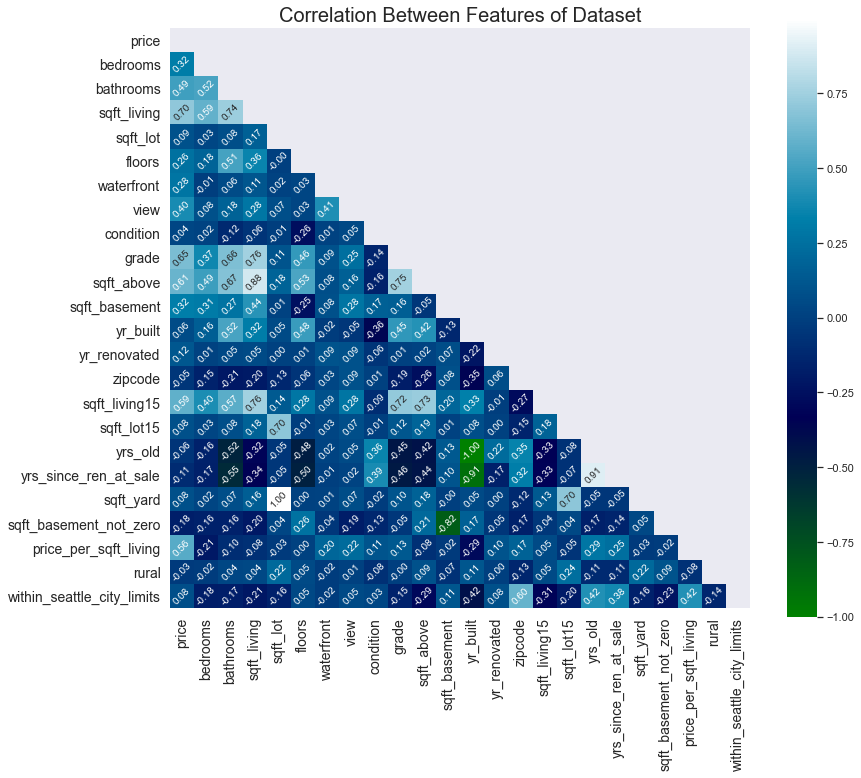

In [31]:
# Creating a correlation matrix
corr_matrix = df.corr()

# Trimming the fat
df_slim = df.drop(columns=['sale_season_fall', 'sale_season_summer', 'sale_season_winter', 'sale_season_spring', 'sale_year', 'sale_month', 'yrs_since_sale', 'yrs_since_renovation', 'lat', 'long'])
corr_matrix_slim = df_slim.corr()

# Creating a mask to restrict heatmap to half, improve readability by not repeating correlation values
mask = np.triu(np.ones_like(corr_matrix_slim, dtype=bool))

# Plotting correlation matrix as seaborn heatmap
fig, ax = plt.subplots(figsize=(13, 11))
ax.set_title('Correlation Between Features of Dataset', size=20)
plt.xticks(size=14)
plt.yticks(size=14)

sns.heatmap(corr_matrix_slim, mask=mask, center=0, annot=True, 
             fmt='.2f', annot_kws={'rotation': 45, 'va':'center'}, square=True, cmap='ocean', );

Predictors correlated with our target **price**:
- **sqft_living**
- **grade**
- sqft_living15
- Bathrooms
- sqft_above
  
We must also be considerate of  in developing a model  multicolinearity with these two
Predictors correlated with each other:  
- Grade and sqft_living are highly correlated with each other (.7)
  - this also goes for sqft_living15 for both
  - this also goes for bathrooms for both

# Further EDA

### id 
  - Unique ID for each home sold
  - This will not contribute to analysis or prediction of property values.
  - **Dropped**

### date 
- Date of the home sale
- date coming in originally in ICS Datetime format
  - YYYYMMDDTHHMMSS
  - year month day time hour minute seconds
  - can drop T, hour, minute and seconds. Doesn't seem to have any info, likely wouldn't be useful neither.
  - the rest can be interpreted as type(DateTime)
- This feature could be very useful for some other observations. As there are other features that refer to time, we could see how a property's sale price was impacted by the age of the building, or the recency of renovation. We will dive in to this further below when we get in to **feature engineering**.

### price
- Price of each home sold.
- **TARGET**
- float dtype
- price mean: 540739.5
- price standard deviation: 373319.0
- price median: 450000.0
- price IQR: 321000.0 — 645000.0
- no null values to drop

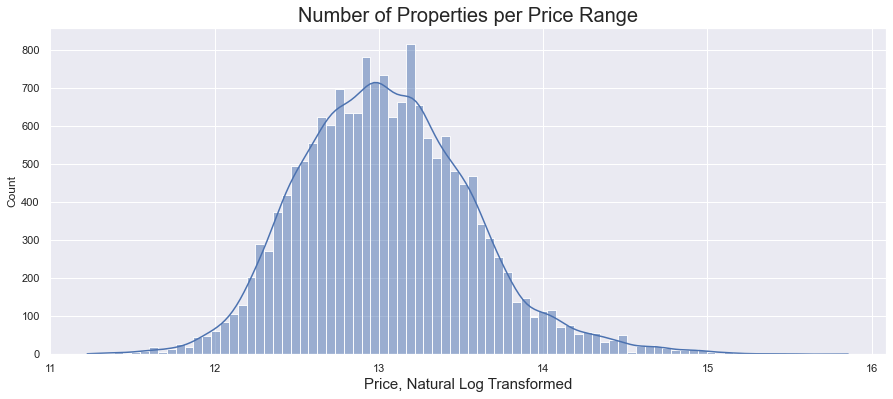

In [33]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price, Natural Log Transformed', size=15)
ax.set_title('Number of Properties per Price Range', size=20)
sns.histplot(data=df, x=np.log(df['price']), kde=True, ax=ax);
# sns.histplot(data=df, x=(df['price']), kde=True, ax=ax);

### bedrooms
- 1 listing with **33 BEDROOMS**. Super outlier. Changed to 3 (median, and likely intended data entry). 
- Scaling down likely best practice over dropping, unless data is wrong.
- 1620 sq_ft living with 6000 sqft_lot, and $\$$640,000 sale price
- 12 properties with 0 bedrooms
  - We will correct for the outliers by:
    - 33 bedroom value imputed to 3
    - properties with more than 8 bedrooms capped down to 8, where prices begin to come down.
    - 12 properties with 0 bedrooms capped up to 1
    - We will leave properties that have 1, despite being below the IQR min

In [237]:
df.bedrooms.value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [233]:
df[df.bedrooms == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
8597,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,6,74,74


In [235]:
df.bedrooms.median()

3.0

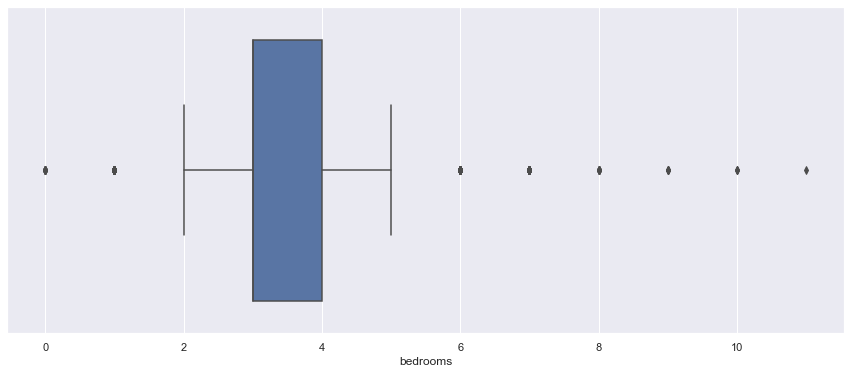

In [650]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=df.bedrooms, ax=ax);

managing 33 bedroom listing **DONE — imputed to 3**:
- plugging in the lat/long reveals a street with several nice, but modest homes. 
- Most likely the property has somewhere closer to the median 3 bedrooms, which would make sense if 33 was entered erroneously in place of 3.
- There is one interesting looking property tucked away on street view that could be a sort of residential complex, but it doesn’t look that big from what I can take away.
- Either way, when building a model, scaling down outliers to within a boxplot max would likely be necessary. Alternatively, impute to median. Could manage with both methods if using another factor for conditions, e.g. ‘sqft_living’ or geofence engineered feature.

managing listed with seemingly high bedroom counts **DONE — capped to 8:
- value counts for each # of bedrooms begin to get significantly lower past 5
- should cap bedrooms for listed over 5, 6, 7, or 8.
  - argument in favor of over 5 or 6:
    - fractional dropoff for number of listings in this range
  - argument in favor of over 8:
    - prices begin to get lower after this value. 

managing listed with <1 bedroom counts **DONE — imputed to 1**:
- could impute 1, or median of properties grouped by sq_ft range
  - could use confidence interval to determine ranges for what is probable for each number of bedrooms possible

In [238]:
df[df.bedrooms == 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
3680,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745,6,108,108
11181,627300145,2014-08-14,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400,6,13,13
17114,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914,6,63,63


- first is small residence. likely data entry error but unsure what to impute. 
  - has 3 bathrooms which should indicate more bedrooms.
  - ALMOST CERTAINLY has had a renovation since 1913 but lists none. That, or the quality of architectural integrity was at its zenith just before WW1. 
- second appears to be 
groupby # bedrooms and median price, mean price

In [239]:
df[df.bedrooms == 11]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
2356,1773100755,2014-08-21,520000.0,11,3.0,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.556,-122.363,1420,4960,6,103,22


### yr_built
- The year a property was initially built
- initial takeaways: Nothing that spectacular here. 
  - will have a lot of utility in engineering other features.
  - one concern is that, in certain instances, **yr_built** is later than the sale year.
    - it is of course possible that certain buyers puchased the property before construction was finished.
    - Issues that could arrise:
      - for **yrs_since_ren_at_sale**, I will have to be careful with values that may be set negative because of this.
- further takeaways: Fascinating connections made when considering history:
  - The value of properties made during WW1 decrease as they were made later in the war
  - There seems to be a spike down, then back up for one year (may be due to outliers), then back down, for the value of properties constructed  around the Great Depression.
  - After a slight recovery of values for properties constructed on the upswing coming out of the Great Depression, there is the deepest trend downwards in value for properties built during WW2, reaching the lowest for the entire span of years.
  - Properties built after WW2 are more consistantly valued with a slow trend upwards for properties built closer to 2001.
  - Properties built shortly after 2001 sold at roughly 75% of that of properties built just before... possibly a reflection of the global economy after 9/11 effecting markets associated with housing development?  
  
  Just remember: **correlation $\neq$ causation.**

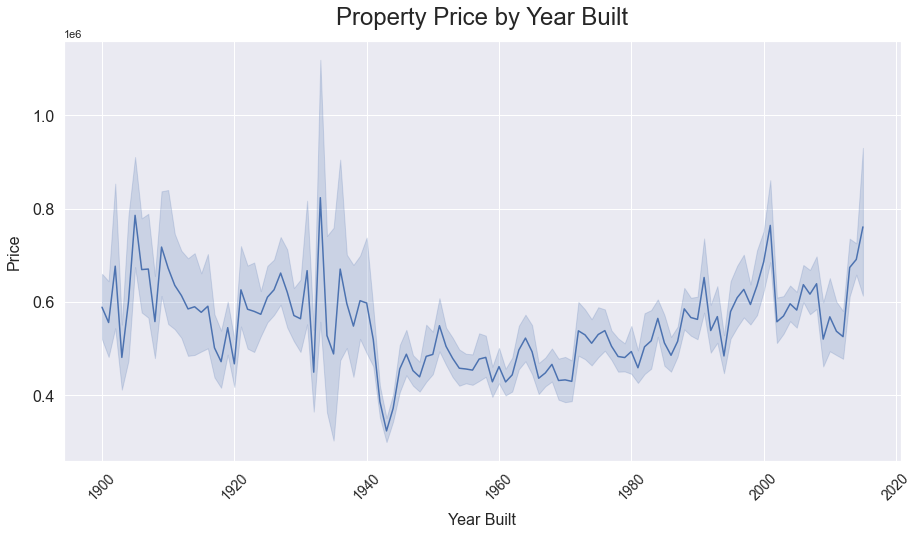

In [138]:
fig, ax = plt.subplots(figsize=(15,8))

ax.set_title('Property Price by Year Built', size=24, pad=16)
ax.set_xlabel('Year Built', size=16, labelpad=10)
ax.set_ylabel('Price', size=16, labelpad=10)
plt.xticks(rotation=45, size=14)
plt.yticks(size=16)
plt.subplots_adjust(bottom=0.15)

sns.lineplot(data=df, x=df.yr_built, y=df.price, ax=ax);

# plt.savefig('images/price_by_year_built', dpi = fig.dpi)
# plt.savefig('images/ALPHA_price_by_year_built', dpi = fig.dpi, transparent = True)

### For further insights taken from my analysis, please view my CRISP-DM EDA notebook file, located in the /EDA directory in the project Github repository.

# Feature Engineering
- yrs_since_sale **ADDED**
- years_old **ADDED**
- yrs_since_renovation **ADDED**
- yrs_since_ren_at_sale **ADDED**
- sqft_yard **ADDED**
- price_per_sqft_living **ADDED** **Note: Not for use in model**
- sale_year **ADDED**
- sale_month **ADDED**
- sale_season
  - **ADDED** as dummy variable columns:
    - **sale_season_winter** 
    - **sale_season_spring** 
    - **sale_season_summer** 
    - **sale_season_fall**
  - Spring is hottest market for real estate
  - **do as dummy variable categories**
    - winter = Jan-Feb-March
    - spring = Apr-May-Jun
    - summer = July-Aug-Sept
    - fall = Oct-Nov-Dec
- Geofencing
  - rural dummy variable **ADDED**
  - within_seattle_city_limits dummy variable **ADDED**
    - Seattle City Limits Fence LAT|LONG:
      - NE Corner:
        - 47.734178 -122.251569
      - SE Corner:
        - 47.495479 -122.251569
      - SW Corner:
        - 47.495479 -122.438230
      - NW Corner:
        - 47.734178 -122.438230
    - Rural Fence:
      - North Fence Post:
        - 47.777204 -121.961527
      - South Fence Post:
        - 47.078583 -121.961527


### city / suburban / rural

Conditional variable that uses **within_seattle_city_limits** and **rural** engineered dummy variable features to separate rural, suburban, and city properties. 

In [47]:
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

# Hypotheses and Statistical Tests

In [48]:
df.price.mean()

540739.5486408329

#### The average property sale price of a property in King County is \$540,900.  
We will take a look at the following with statistical tests:  
1. whether waterfront properties have a different sale price on average than those without. 
  - Method: two sample, paired t-test
2. whether or not there is a difference between the mean property sale price for properties that are within Seattle city limits, in the suburbs of Seattle, and further out in the rural parts of King County.
  - Method: ANOVA f-test with 3 samples.
3. whether or not the season that a property sale occurred has a statistically significant impact on sale price.
  - Method: ANOVA f-test with 4 samples.

## 1. 
 - $H_0$: The mean sale price of waterfront properties is not different from the mean price of non-waterfront properties.
 - $H_a$: The mean sale price of waterfront properties is different from the mean price of non-waterfront properties.

In [67]:
from matplotlib.lines import Line2D

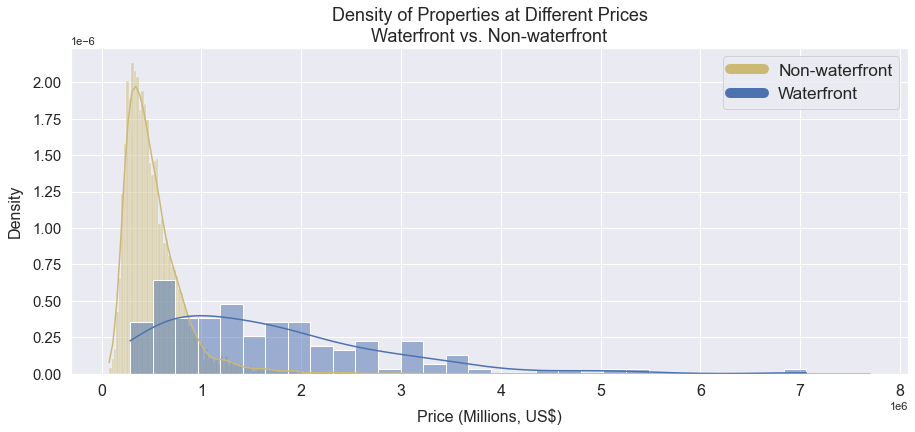

In [143]:
custom_legend = [
    Line2D([0], [0], color='y', lw=10),
    Line2D([0], [0], color='b', lw=10)
]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Density of Properties at Different Prices\nWaterfront vs. Non-waterfront', size = 18)
ax.legend(custom_legend, ['Non-waterfront', 'Waterfront'], fontsize='xx-large')
ax.set_xlabel('Price (Millions, US$)', size = 16, labelpad = 10)
ax.set_ylabel('Density', size = 16, labelpad = 10)
plt.xticks(size=16)
plt.yticks(size=15)

sns.histplot(data = df, x = df[df.waterfront == 0].price, 
             color = 'y', label = 'Non-waterfront', kde = True, stat = 'density', ax = ax)
sns.histplot(data = df, x = df[df.waterfront == 1].price, 
             color = 'b', label = 'Waterfront', bins = 30, kde = True, stat = 'density', ax = ax);

# plt.savefig('images/waterfront.png', dpi = fig.dpi)
# plt.savefig('images/ALPHA_waterfront.png', dpi = fig.dpi, transparent = True)

In [907]:
a = df[df.waterfront == 1].price
b = df[df.waterfront == 0].price

stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='omit')

Ttest_indResult(statistic=37.71740313594821, pvalue=3.10797062240795e-299)

### Conclusion:  
The t-test outcome has a p-value close to 0. I reject the null hypothesis that the mean sale price of waterfront properties is not different from the mean price of non-waterfront properties.

Though only 138 properties in our dataset represent waterfront, it will be worthy of distinguishing these properties in our model, though we must run a correlation matrix again at the beginning stage of building our model, and be vigilant against multicolinearity.

In [1024]:
len(df[df.waterfront == 1])

138

<br><br><br>

## 2.  
 - $H_0$: The mean sale price of properties within city limits of Seattle, suburban King County, and rural King County are not different.  
 - $H_a$: $H_0$ is not true.

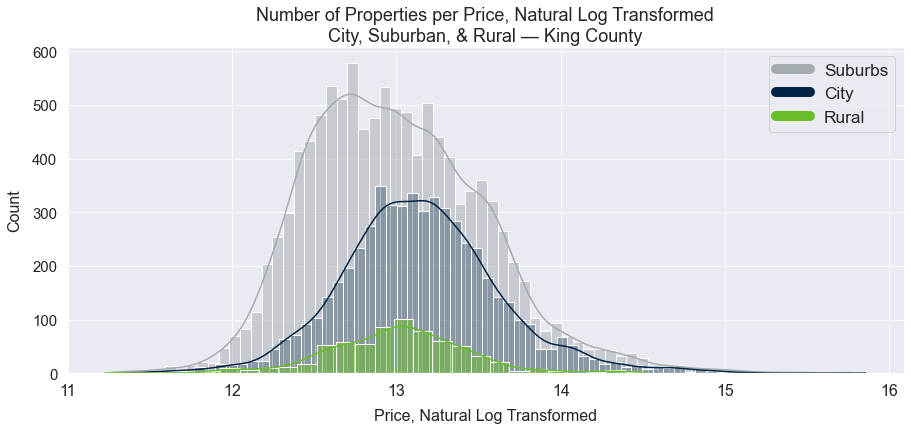

In [146]:
custom_legend = [
    Line2D([0], [0], color='#A5ACAF', lw=10),
    Line2D([0], [0], color='#002244', lw=10),
    Line2D([0], [0], color='#69BE28', lw=10)
]

rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Number of Properties per Price, Natural Log Transformed\nCity, Suburban, & Rural — King County', size=18)
ax.legend(custom_legend, ['Suburbs', 'City', 'Rural'], fontsize='xx-large')
ax.set_xlabel('Price, Natural Log Transformed', size = 16, labelpad = 10)
ax.set_ylabel('Count', size = 16, labelpad = 10)
plt.xticks(size=16)
plt.yticks(size=15)

sns.histplot(np.log(suburb['price']), label = 'Suburbs', kde = True, color = '#A5ACAF')
sns.histplot(np.log(city['price']), label = 'Suburbs', kde = True, color = '#002244', alpha=.3)
sns.histplot(np.log(rural['price']), label = 'Suburbs', kde = True, color = '#69BE28');

# plt.savefig('images/city_sub_rural_LOG.png', dpi = fig.dpi)
# plt.savefig('images/ALPHA_city_sub_rural_LOG.png', dpi = fig.dpi, transparent = True)

- Let's view again by density to get a better sense of comparision between distributions between these three.

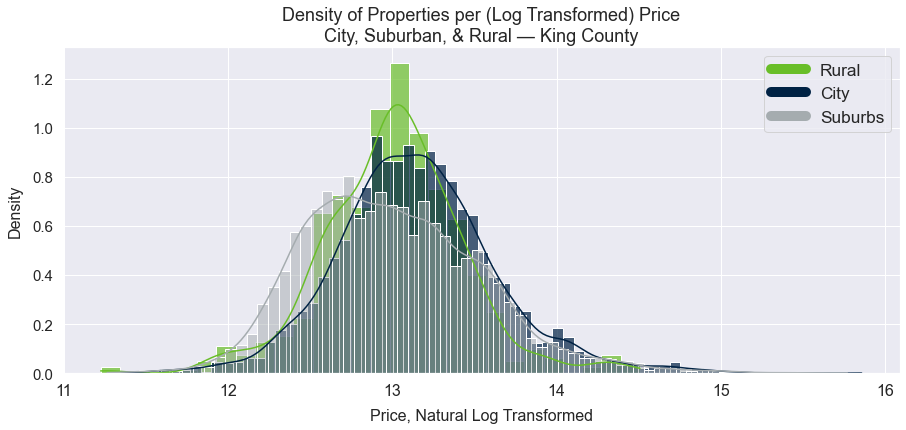

In [148]:
custom_legend = [
    Line2D([0], [0], color='#69BE28', lw=10),
    Line2D([0], [0], color='#002244', lw=10),
    Line2D([0], [0], color='#A5ACAF', lw=10)
]

rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Density of Properties per (Log Transformed) Price\nCity, Suburban, & Rural — King County', size = 18)
ax.legend(custom_legend, ['Rural', 'City', 'Suburbs'], fontsize = 'xx-large')
ax.set_xlabel('Price, Natural Log Transformed', size = 16, labelpad = 10)
ax.set_ylabel('Density', size = 16, labelpad = 10)
plt.xticks(size=16)
plt.yticks(size=15)

sns.histplot(np.log(rural['price']), label = 'Rural', kde = True, color = '#69BE28', alpha = .7, stat = 'density')
sns.histplot(np.log(city['price']), label = 'City', kde = True, color = '#002244', alpha = .7, stat = 'density')
sns.histplot(np.log(suburb['price']), label = 'Suburbs', kde = True, color = '#A5ACAF', stat = 'density');

# plt.savefig('images/city_sub_rural.png', dpi = fig.dpi)
# plt.savefig('images/ALPHA_city_sub_rural.png', transparent=True)

In [1022]:
stats.f_oneway(rural['price'], suburb['price'], city['price'])

F_onewayResult(statistic=54.32021156599743, pvalue=3.040352990681827e-24)

In [54]:
print('Median Sale Prices:') 
print(f'Rural: {rural.price.median()}')
print(f'Suburbs: {suburb.price.median()}')
print(f'City: {city.price.median()}')

Median Sale Prices:
Rural: 450000.0
Suburbs: 425000.0
City: 500000.0


### Conclusion:  
The ANOVA test outcome has a p-value close to 0. I reject the null hypothesis that the mean price of properties within city limits of Seattle, suburban King County, and rural King County are not different.  
  
We should certainly consider this category worthy of distinction when we build our predictive model.

<br><br><br>

## 3. 
 - $H_0$: The mean sale price of properties sold in different seasons is not different during different seasons.  
 - $H_a$: $H_0$ is not true.

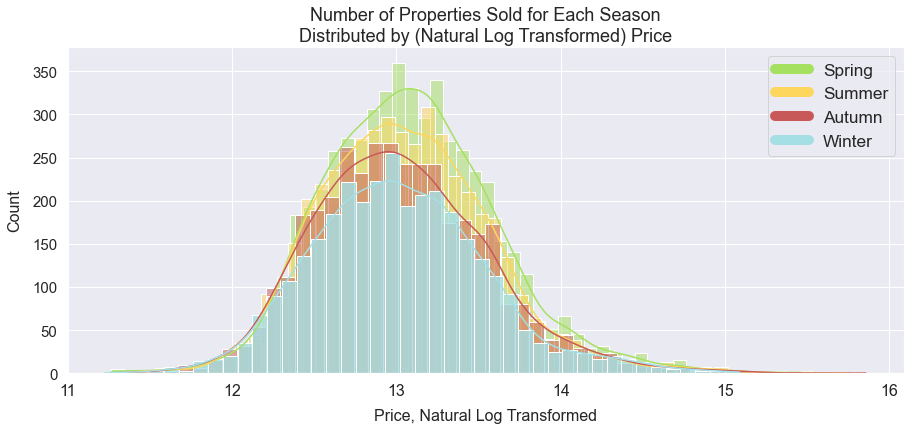

In [151]:
custom_legend = [
    Line2D([0], [0], color='#a5e060', lw=10),
    Line2D([0], [0], color='#fdd65d', lw=10),
    Line2D([0], [0], color='#c75959', lw=10),
    Line2D([0], [0], color='#a5dfe6', lw=10)
]

winter = df[df.sale_season_winter == 1].price
spring = df[df.sale_season_spring == 1].price
summer = df[df.sale_season_summer == 1].price
fall = df[df.sale_season_fall == 1].price

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Number of Properties Sold for Each Season\nDistributed by (Natural Log Transformed) Price', size=18)
ax.legend(custom_legend, ['Spring', 'Summer', 'Autumn', 'Winter'], fontsize = 'xx-large')
ax.set_xlabel('Price, Natural Log Transformed', size = 16, labelpad = 10)
ax.set_ylabel('Count', size = 16, labelpad = 10)
plt.xticks(size=16)
plt.yticks(size=15)

sns.histplot(np.log(spring), kde = True, color = '#a5e060')
sns.histplot(np.log(summer), kde = True, color = '#fdd65d')
sns.histplot(np.log(fall), kde = True, color = '#c75959', alpha = .5)
sns.histplot(np.log(winter), kde = True, color = '#a5dfe6', alpha = .8);

# plt.savefig('images/Seasons_LOG.png', dpi = fig.dpi)
# plt.savefig('images/ALPHA_Seasons_LOG.png', dpi = fig.dpi, transparent=True)

- Again, by density to get a better sense of comparision between distributions between these three.

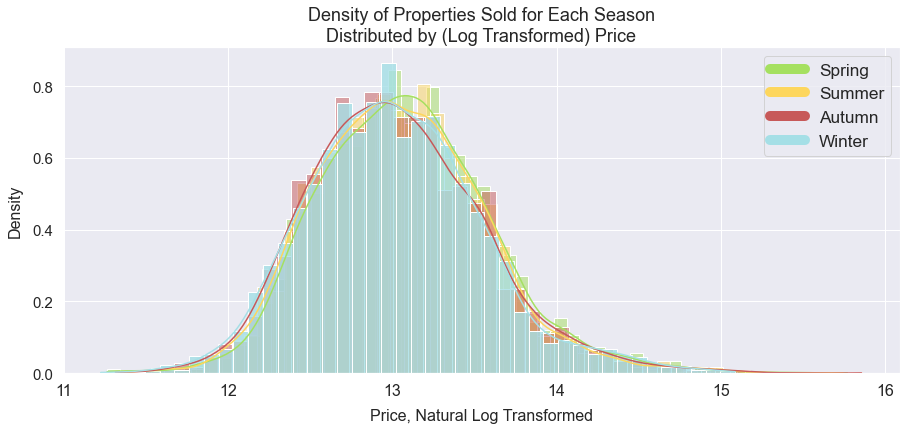

In [154]:
winter = df[df.sale_season_winter == 1].price
spring = df[df.sale_season_spring == 1].price
summer = df[df.sale_season_summer == 1].price
fall = df[df.sale_season_fall == 1].price

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Density of Properties Sold for Each Season\nDistributed by (Log Transformed) Price', size=18)
ax.legend(custom_legend, ['Spring', 'Summer', 'Autumn', 'Winter'], fontsize = 'xx-large')
ax.set_xlabel('Price, Natural Log Transformed', size = 16, labelpad = 10)
ax.set_ylabel('Density', size = 16, labelpad = 10)
plt.xticks(size=16)
plt.yticks(size=15)

sns.histplot(np.log(spring), label = 'Spring', kde = True, color = '#a5e060', stat='density')
sns.histplot(np.log(summer), label = 'Summer', kde = True, color = '#fdd65d', stat='density')
sns.histplot(np.log(fall), label = 'Autumn', kde = True, color = '#c75959', alpha = .5, stat='density')
sns.histplot(np.log(winter), label = 'Winter', kde = True, color = '#a5dfe6', alpha = .8, stat='density');

# plt.savefig('images/Seasons_LOG.png', dpi = fig.dpi)
# plt.savefig('images/ALPHA_Seasons_LOG.png', dpi = fig.dpi, transparent=True)

In [1106]:
stats.f_oneway(winter, spring, summer, fall)

F_onewayResult(statistic=7.019439879954201, pvalue=0.00010298073038170776)

### Conclusion:  
  We reject the null hypothesis that there is no differences in the mean sale price of properties sold in different seasons.
  
  As season may be considered categorical a feature, we will create dummy variables to manage them in the model.

<br><br><br>

# Training a Model

In [296]:
df.drop(columns='price_per_sqft_living', inplace=True)

In [442]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

### Polynomial Features

Interactions and Polynomial features can help us capture some of the unseen relationships between between our features in our model, with the intention of improving the fit. Below we will attempt to generate some polynomial features from all of the features that we have arrived to at this point, run a model with the new polynomial features, and evaluate using the training and testing data **Root Mean Squared Error**.

In [443]:
# training_df = None
# training_df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode'], drop_first=True)

In [444]:
training_df = None
training_df = df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sale_year'], axis=1)

In [445]:
training_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'yrs_since_sale', 'yrs_old', 'yrs_since_renovation',
       'yrs_since_ren_at_sale', 'sqft_yard', 'sqft_basement_not_zero', 'rural',
       'within_seattle_city_limits', 'sale_month', 'sale_season_winter',
       'sale_season_spring', 'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [446]:
df_features=training_df.drop(columns='price')
target = df['price']

In [447]:
df_features.isnull().mean().sum() # checking to ensure there are no null values in my features training dataset 

0.0

In [448]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(df_features)
poly_columns = poly.get_feature_names(df_features.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms zipcode,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms yrs_since_sale,bedrooms yrs_old,bedrooms yrs_since_renovation,bedrooms yrs_since_ren_at_sale,bedrooms sqft_yard,bedrooms sqft_basement_not_zero,bedrooms rural,bedrooms within_seattle_city_limits,bedrooms sale_month,...,yrs_since_ren_at_sale sale_month,yrs_since_ren_at_sale sale_season_winter,yrs_since_ren_at_sale sale_season_spring,yrs_since_ren_at_sale sale_season_summer,yrs_since_ren_at_sale sale_season_fall,sqft_yard^2,sqft_yard sqft_basement_not_zero,sqft_yard rural,sqft_yard within_seattle_city_limits,sqft_yard sale_month,sqft_yard sale_season_winter,sqft_yard sale_season_spring,sqft_yard sale_season_summer,sqft_yard sale_season_fall,sqft_basement_not_zero^2,sqft_basement_not_zero rural,sqft_basement_not_zero within_seattle_city_limits,sqft_basement_not_zero sale_month,sqft_basement_not_zero sale_season_winter,sqft_basement_not_zero sale_season_spring,sqft_basement_not_zero sale_season_summer,sqft_basement_not_zero sale_season_fall,rural^2,rural within_seattle_city_limits,rural sale_month,rural sale_season_winter,rural sale_season_spring,rural sale_season_summer,rural sale_season_fall,within_seattle_city_limits^2,within_seattle_city_limits sale_month,within_seattle_city_limits sale_season_winter,within_seattle_city_limits sale_season_spring,within_seattle_city_limits sale_season_summer,within_seattle_city_limits sale_season_fall,sale_month^2,sale_month sale_season_winter,sale_month sale_season_spring,sale_month sale_season_summer,sale_month sale_season_fall,sale_season_winter^2,sale_season_winter sale_season_spring,sale_season_winter sale_season_summer,sale_season_winter sale_season_fall,sale_season_spring^2,sale_season_spring sale_season_summer,sale_season_spring sale_season_fall,sale_season_summer^2,sale_season_summer sale_season_fall,sale_season_fall^2
0,4.0,2.25,2070.0,8893.0,2.0,0.0,0.0,4.0,8.0,2070.0,0.0,98058.0,2390.0,7700.0,6.0,35.0,35.0,29.0,7858.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,16.0,9.0,8280.0,35572.0,8.0,0.0,0.0,16.0,32.0,8280.0,0.0,392232.0,9560.0,30800.0,24.0,140.0,140.0,116.0,31432.0,4.0,0.0,0.0,40.0,...,290.0,0.0,0.0,0.0,29.0,61748164.0,7858.0,0.0,0.0,78580.0,0.0,0.0,0.0,7858.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.0,3.00,2900.0,6730.0,1.0,0.0,0.0,5.0,8.0,1830.0,1070.0,98115.0,2370.0,6283.0,6.0,44.0,44.0,38.0,3830.0,0.0,0.0,1.0,8.0,0.0,0.0,1.0,0.0,25.0,15.0,14500.0,33650.0,5.0,0.0,0.0,25.0,40.0,9150.0,5350.0,490575.0,11850.0,31415.0,30.0,220.0,220.0,190.0,19150.0,0.0,0.0,5.0,40.0,...,304.0,0.0,0.0,38.0,0.0,14668900.0,0.0,0.0,3830.0,30640.0,0.0,0.0,3830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,1.0,0.0,64.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,2.50,3770.0,10893.0,2.0,0.0,2.0,3.0,11.0,3770.0,0.0,98006.0,3710.0,9685.0,6.0,24.0,24.0,18.0,9008.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,16.0,10.0,15080.0,43572.0,8.0,0.0,8.0,12.0,44.0,15080.0,0.0,392024.0,14840.0,38740.0,24.0,96.0,96.0,72.0,36032.0,4.0,0.0,0.0,32.0,...,144.0,0.0,0.0,18.0,0.0,81144064.0,9008.0,0.0,0.0,72064.0,0.0,0.0,9008.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.0,3.50,4560.0,14608.0,2.0,0.0,2.0,3.0,11.0,4560.0,0.0,98034.0,4050.0,14226.0,5.0,31.0,31.0,26.0,123

In [449]:
len(df_poly.columns) # yowza

405

In [450]:
X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=9, test_size=0.2)

# instantiating a linear regression object
lm = LinearRegression()

# fitting the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

In [451]:
# using fitted model to predict on test data
y_pred = lm.predict(X_test)

# we can use sklearn's metrics package to evaluate the RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training RMSE: ', int(train_rmse), "vs. Testing RMSE: ", int(test_rmse))

Testing Root Mean Squared Error: 183451.7271893806
Training RMSE:  170552 vs. Testing RMSE:  183451


- Training RMSE:  170552  
- Testing RMSE:  183,451  
  
  That's not so bad! We're under 200k for both testing and training. Let's see if we can remove some of the noise added by too many polynomial features.

# Feature Selection

### Select K-Best

Selecting on k-best is a method for feature selection. We can use the feature selection SelectKBest, f_regression, and mutual_info_regression packages from SciKit-Learn to decide which features of the dataset will be most useful for our model.

In [452]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms zipcode,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms yrs_since_sale,bedrooms yrs_old,bedrooms yrs_since_renovation,bedrooms yrs_since_ren_at_sale,bedrooms sqft_yard,bedrooms sqft_basement_not_zero,bedrooms rural,bedrooms within_seattle_city_limits,bedrooms sale_month,...,yrs_since_ren_at_sale sale_month,yrs_since_ren_at_sale sale_season_winter,yrs_since_ren_at_sale sale_season_spring,yrs_since_ren_at_sale sale_season_summer,yrs_since_ren_at_sale sale_season_fall,sqft_yard^2,sqft_yard sqft_basement_not_zero,sqft_yard rural,sqft_yard within_seattle_city_limits,sqft_yard sale_month,sqft_yard sale_season_winter,sqft_yard sale_season_spring,sqft_yard sale_season_summer,sqft_yard sale_season_fall,sqft_basement_not_zero^2,sqft_basement_not_zero rural,sqft_basement_not_zero within_seattle_city_limits,sqft_basement_not_zero sale_month,sqft_basement_not_zero sale_season_winter,sqft_basement_not_zero sale_season_spring,sqft_basement_not_zero sale_season_summer,sqft_basement_not_zero sale_season_fall,rural^2,rural within_seattle_city_limits,rural sale_month,rural sale_season_winter,rural sale_season_spring,rural sale_season_summer,rural sale_season_fall,within_seattle_city_limits^2,within_seattle_city_limits sale_month,within_seattle_city_limits sale_season_winter,within_seattle_city_limits sale_season_spring,within_seattle_city_limits sale_season_summer,within_seattle_city_limits sale_season_fall,sale_month^2,sale_month sale_season_winter,sale_month sale_season_spring,sale_month sale_season_summer,sale_month sale_season_fall,sale_season_winter^2,sale_season_winter sale_season_spring,sale_season_winter sale_season_summer,sale_season_winter sale_season_fall,sale_season_spring^2,sale_season_spring sale_season_summer,sale_season_spring sale_season_fall,sale_season_summer^2,sale_season_summer sale_season_fall,sale_season_fall^2
7189,4.0,2.25,1930.0,8338.0,1.0,0.0,0.0,3.0,8.0,1930.0,0.0,98125.0,2280.0,7616.0,5.0,53.0,53.0,48.0,6408.000000,1.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,16.0,9.0,7720.0,33352.0,4.0,0.0,0.0,12.0,32.0,7720.0,0.0,392500.0,9120.0,30464.0,20.0,212.0,212.0,192.0,25632.0,4.0,0.0,4.0,12.0,...,144.0,48.0,0.0,0.0,0.0,4.106246e+07,6408.000000,0.0,6408.000000,19224.0,6408.000000,0.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12378,2.0,1.00,1060.0,7700.0,1.0,0.0,0.0,3.0,7.0,820.0,240.0,98055.0,1370.0,8833.0,6.0,40.0,40.0,34.0,6640.000000,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,4.0,2.0,2120.0,15400.0,2.0,0.0,0.0,6.0,14.0,1640.0,480.0,196110.0,2740.0,17666.0,12.0,80.0,80.0,68.0,13280.0,0.0,0.0,0.0,14.0,...,238.0,0.0,0.0,34.0,0.0,4.408960e+07,0.000000,0.0,0.000000,46480.0,0.000000,0.0,6640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5664,3.0,2.00,1390.0,5127.0,1.0,0.0,0.0,3.0,8.0,1390.0,0.0,98055.0,1960.0,5019.0,6.0,31.0,31.0,25.0,3737.000000,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,9.0,6.0,4170.0,15381.0,3.0,0.0,0.0,9.0,24.0,4170.0,0.0,294165.0,5880.0,15057.0,18.0,93.0,93.0,75.0,11211.0,3.0,0.0,0.0,24.0,...,200.0,0.0,0.0,25.0,0.0,1.396517e+07,3737.000000,0.0,0.000000,29896.0,0.000000,0.0,3737.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
927,3.0,1.00,1560.0,3960.0,1.5,0.0,0.0,4.0,7.0,1560

In [453]:
selector = SelectKBest(f_regression, k=200) # k will equal the number of features that we would like to select down to.

selector.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=200, score_func=<function f_regression at 0x7f9c3b846700>)

In [454]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [455]:
list(selected_columns) # these are the lovely features that we're left with

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_basement_not_zero',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms sqft_living',
 'bedrooms sqft_lot',
 'bedrooms floors',
 'bedrooms waterfront',
 'bedrooms view',
 'bedrooms condition',
 'bedrooms grade',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms zipcode',
 'bedrooms sqft_living15',
 'bedrooms sqft_lot15',
 'bedrooms yrs_since_sale',
 'bedrooms sqft_yard',
 'bedrooms within_seattle_city_limits',
 'bedrooms sale_month',
 'bathrooms^2',
 'bathrooms sqft_living',
 'bathrooms sqft_lot',
 'bathrooms floors',
 'bathrooms waterfront',
 'bathrooms view',
 'bathrooms condition',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms zipcode',
 'bathrooms sqft_living15',
 'bathrooms sqft_lot15',
 'bathrooms yrs_since_sale',
 'bathrooms yrs_old',
 'bathrooms yrs_since_renovation',
 'bathrooms yrs_sin

Now, let's see if we can fit a better model with only the 200 best features.

In [456]:
# instantiating a linear regression object
lm_kbest = LinearRegression()

# fitting the linear regression to the data
lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])

# let's evaluate using sklearn's metrics package again
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))

print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 175115.15859305626
Testing Root Mean Squared Error: 184115.3727858357


- Training Root Mean Squared Error: 175,115  
- Testing Root Mean Squared Error: 184115  
    
    That didn't seem to do much better (if at all), but we're down under 200k RMSE, and our training and testing RMSE are not too far off from each other.
    
    Let's give another feature elimination method ago and see which will provide a better predictive model.

### Recursive Feature Elimination, Cross Validation

RFECV is a popular, flexible method for feature selection. We will use the feature selection RFECV package from SciKit-Learn to decide which features of the dataset will be most useful for our model.

- First we will need to select which features of our dataset we would like to use, and transform/create dummy variables for others if necessary.
- 'price' is my target
- for predictors I will use:  
       'bedrooms', 'bathrooms', 'zipcode', 'grade',
       'sqft_living', 'floors', 'waterfront', 
       'yrs_old', 'yrs_since_ren_at_sale', 'sqft_yard',
       'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall',
       'view', 'condition', 'sqft_above', 'sqft_lot',  
       'sqft_basement', 'sqft_living15', 'sqft_lot15',  
       'yrs_since_sale', 'yrs_since_renovation, or price_per_sqft_living.
- Some dummy variables were created above, but I would also like to create dummy variables for:  
        'zipcode', 'bedrooms', 'bathrooms', and 'grade'
- I will not use:  
        'date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'
        
- First considerations of other features to drop:  
        'view', 'condition', 'sqft_above',  
        'sqft_basement', 'sqft_living15', 'sqft_lot15',  
        'yrs_since_sale', 'yrs_since_renovation, or price_per_sqft_living.

In [457]:
training_df = None
training_df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode'], drop_first=True)

In [458]:
training_df.head()

,date,price,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,...,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,2.0,0,0,4,2070,0,1986,0,47.4388,-122.162,2390,7700,6,35,35,29,7858.0,1,0,0,10,2014,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,1.0,0,0,5,1830,1070,1977,0,47.6784,-122.285,2370,6283,6,44,44,38,3830.0,0,0,1,8,2014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,2.0,0,2,3,3770,0,1997,0,47.5646,-122.129,3710,9685,6,24,24,18,9008.0,1,0,0,8,2014,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,2.0,0,2,3,4560,0,1990,0,47.6995,-122.228,4050,14226,5,31,31,26,12328.0,1,0,0,3,2015,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,2.0,0,0,3,2550,0,2004,0,47.6647,-122.083,2250,4050,6,17,17,11,4101.0,1,0,0,7,2014,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [459]:
training_df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'], axis=1, inplace=True)

In [460]:
training_df.columns

Index(['price', 'sqft_living', 'floors', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=119)

In [461]:
df_features=training_df.drop(columns='price')

target = df['price']

In [462]:
df_features.isna().mean().sum() # checking to ensure there are no null values in my features training dataset 

0.0

In [463]:
# creating our X-train and y-train variables: model training datasets for our predictors and target.
# we do this above in polynomial features, but lets start fresh for the next model
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9, test_size=0.2)

In [464]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [465]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# fitting recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [466]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [467]:
list(removed_rfe)

[]

In [468]:
len(list(selected_rfe))

118

In [469]:
len(df_features)

17290

In [470]:
# instantiating a linear regression object
lm_rfe = LinearRegression()

# fitting the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 157023.02216771455
Testing Root Mean Squared Error: 156040.26525763958


- Training Root Mean Squared Error: 157130.04475253646
- Testing Root Mean Squared Error: 155888.02316166498
  
  That's a good place to start. Now let's see how this model fares with the holdout dataset.

But first... let's just check to see what dummying floors, view, and condition does to our model...

In [471]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [472]:
training_df = None
training_df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode', 'floors', 'view', 'condition'], drop_first=True)

In [473]:
training_df.head()

,date,price,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,grade_6,grade_7,grade_8,...,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,view_1,view_2,view_3,view_4,condition_2,condition_3,condition_4,condition_5
0,2014-10-06,365000.0,2070,8893,0,2070,0,1986,0,47.4388,-122.162,2390,7700,6,35,35,29,7858.0,1,0,0,10,2014,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,2014-08-21,865000.0,2900,6730,0,1830,1070,1977,0,47.6784,-122.285,2370,6283,6,44,44,38,3830.0,0,0,1,8,2014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2014-08-15,1038000.0,3770,10893,0,3770,0,1997,0,47.5646,-122.129,3710,9685,6,24,24,18,9008.0,1,0,0,8,2014,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,2015-03-31,1490000.0,4560,14608,0,4560,0,1990,0,47.6995,-122.228,4050,14226,5,31,31,26,12328.0,1,0,0,3,2015,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,2014-07-14,711000.0,2550,5376,0,2550,0,2004,0,47.6647,-122.083,2250,4050,6,17,17,11,4101.0,1,0,0,7,2014,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [474]:
training_df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'], axis=1, inplace=True)

In [475]:
df_features=training_df.drop(columns='price')

target = df['price']

In [476]:
df_features.isnull().mean().sum() # checking to ensure there are no null values in my features training dataset 

0.0

In [477]:
# creating our X-train and y-train variables: model training datasets for our predictors and target.
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9, test_size=0.2)

In [478]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [479]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# fitting recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [480]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [487]:
X_train.shape

(13832, 128)

In [481]:
list(removed_rfe)

[]

In [482]:
len(list(selected_rfe))

128

In [483]:
len(df_features)

17290

In [484]:
# instantiating a linear regression object
lm_rfe = LinearRegression()

# fitting the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 155973.30701870698
Testing Root Mean Squared Error: 154866.3299009289


- Training RMSE: 155973
- Testing RMSE: 154,866

After evaluating all models, the one above outputs the lowest RMSE, our primary evaluation metric. The testing RMSE isn't far off from the training RMSE, which suggests that our model is not overfitting the data. Now we can refit this model to our entire dataset, and output using pickle.

In [493]:
df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode', 'floors', 'view', 'condition'], drop_first=True)
# df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'], axis=1, inplace=True)
lm_final = LinearRegression()
lm_final = lm_final.fit(df[selected_rfe], df['price'])

In [494]:
pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [499]:
pickle_out = open('features.pickle', 'wb')
pickle.dump(list(selected_rfe), pickle_out)
pickle_out.close()

# Final Statements

There is no one correct approach to evaluating and using the data, but to go further, it would be useful to improve my domain expertise in real estate, develop a deeper familiarity with the market in King County, and utilize the insights of others who may have a different creative approach.  
  
Though I am satisfied with my final model, there is always room to grow. Were I to devote more time to this dataset, there are many areas that I would love to explore a bit more in depth.  On top of everything, I would be curious to use this project to evaluate real estate markets outside of King County.

### Further Cleaning to Consider:

Experimenting with cleaning a bit more is the key to a better model. Experimenting with imputing different values a bit more would illuminate connections that had previously gone unseen. I would be very interested in playing a bit more with imputing different values for the predictors most heavily correlated with price, such as sqft_living. I'm not sure if there was a moment where I had come across a value that didn't make logical sense for that feature specifically, though I'm sure many exist in the dataset.

### Further Feature Engineering to Consider:
  - inflation adjuster
    - note: Would not be necessary if holdout dataset is from same years, but would be great when building a predictive model for future data with sale dates from other years.
  - deeper time series analysis that imputes changes in markets from outside data, such as twitter, or news feeds. It could be possible to develop a model that considers events that effect the property market.
  - more Geofencing that could be useful:
    - pinpoint locations that are near certain locations. Such as:
    - schools
    - universities
    - parks
    - beaches
    - lakes
    - general waterfront, if 'waterfront' column proves to be too dirty
    - museums
    - highways (or other nuisant noise polluters)
    - methadone clinics
    - homeless shelters
    - within city limits or more rural (appears to be divided by north-to-south routes 203-202-18-169-410) 
    - islands vs mainland
      - Vashon Island
      - Mercer Island
      - Maury Island
    - major employers
      - The Boeing Co. (71,829 employed statewide)
      - Amazon.com (60,000)
      - Microsoft Corp. (55,063)
      - Joint Base Lewis-McChord (54,000)
      - University of Washington Seattle (46,824)
      - source https://www.bizjournals.com/seattle/subscriber-only/2020/06/19/largest-employers.html

<br><br><br><br><br><br><br><br><br><br><br><br>

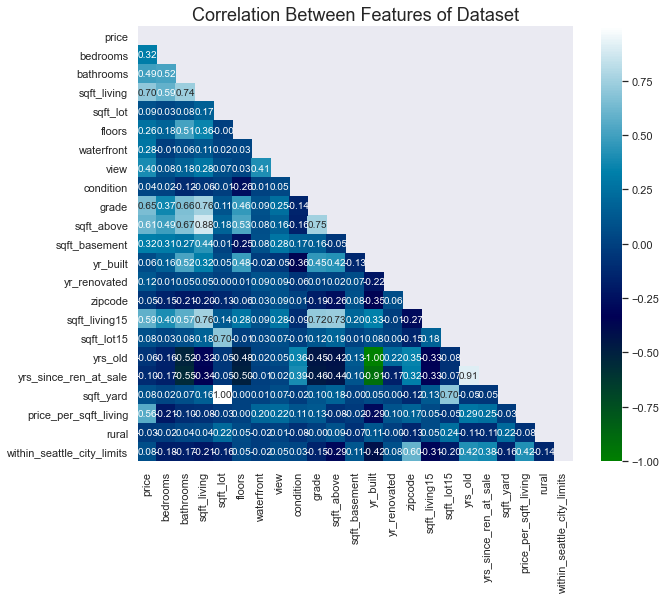

In [99]:
# Creating a correlation matrix
corr_matrix = df.corr()

# Trimming the fat
df_slim = df.drop(columns=['sale_season_fall', 'sale_season_summer', 'sale_season_winter', 'sale_season_spring', 'sale_year', 'sale_month', 'yrs_since_sale', 'yrs_since_renovation', 'lat', 'long'])
corr_matrix_slim = df_slim.corr()

# Creating a mask to restrict heatmap to half, improve readability by not repeating correlation values
mask = np.triu(np.ones_like(corr_matrix_slim, dtype=bool))

# Plotting correlation matrix as seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Correlation Between Features of Dataset', size=18)

sns.heatmap(corr_matrix_slim, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap='ocean', );

In [510]:
for i in selected_rfe:
    print(i)

sqft_living
waterfront
sqft_above
sqft_basement
sqft_living15
sqft_lot15
yrs_since_sale
yrs_old
yrs_since_renovation
yrs_since_ren_at_sale
sqft_yard
sqft_basement_not_zero
rural
within_seattle_city_limits
sale_month
sale_year
sale_season_winter
sale_season_spring
sale_season_summer
sale_season_fall
bedrooms_2
bedrooms_3
bedrooms_4
bedrooms_5
bedrooms_6
bedrooms_7
bedrooms_8
bathrooms_1.0
bathrooms_1.25
bathrooms_1.5
bathrooms_1.75
bathrooms_2.0
bathrooms_2.25
bathrooms_2.5
bathrooms_2.75
bathrooms_3.0
bathrooms_3.25
bathrooms_3.5
bathrooms_3.75
bathrooms_4.0
grade_6
grade_7
grade_8
grade_9
grade_10
grade_11
zipcode_98002
zipcode_98003
zipcode_98004
zipcode_98005
zipcode_98006
zipcode_98007
zipcode_98008
zipcode_98010
zipcode_98011
zipcode_98014
zipcode_98019
zipcode_98022
zipcode_98023
zipcode_98024
zipcode_98027
zipcode_98028
zipcode_98029
zipcode_98030
zipcode_98031
zipcode_98032
zipcode_98033
zipcode_98034
zipcode_98038
zipcode_98039
zipcode_98040
zipcode_98042
zipcode_98045
zipcode

<div align="center"; alpha=0.5>Thank you